# Part 5: Prediction

## Imports & Configurations

In [51]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -O ./spark-3.3.1-bin-hadoop3.tgz  https://dlcdn.apache.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz
!tar zxvf ./spark-3.3.1-bin-hadoop3.tgz
!pip install findspark
!pip install pyspark

--2023-02-26 11:26:49--  https://dlcdn.apache.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2023-02-26 11:26:49 ERROR 404: Not Found.


gzip: stdin: unexpected end of file
tar: Child returned status 1
tar: Error is not recoverable: exiting now
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [52]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
import findspark
import random
import pyspark
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from pyspark.sql import SparkSession
from pyspark.ml.feature import Imputer
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.ml.feature import VectorAssembler,Tokenizer,MinMaxScaler
from pyspark.ml.classification import RandomForestClassifier, LinearSVC
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.functions import vector_to_array
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, ArrayType
from pyspark.ml.linalg import Vectors
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

import time
import re
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords

In [54]:
spark = SparkSession.builder.config("spark.driver.memory", "2g")\
    .config("spark.executor.memory", "2g") \
    .config('spark.executor.cores', '3') \
    .config('spark.cores.max', '3') \
    .appName("predict").getOrCreate()

spark.conf.set("spark.sql.shuffle.partitions", 10)
spark.conf.set("spark.default.parallelism", 10)

## Read data

In [55]:
# Use Spark to read the csv file.
df = spark.read.csv("/content/drive/MyDrive/BDP Final Project/Notebooks/Data/name_data.csv",
                    inferSchema=True,
                    header=True)

In [56]:
df.show()

+-------------+--------------------+----------+--------------------+--------------------+-------------+-----------+------------------+--------+-------+--------+----------------+-------------------+--------------+-------------------+-----------------+-------------------+----------------------+----------------------+---------------------+------------+---------+----------+----------------+----------------+-------------+----------------+-------------+------------------------------+------------------------------+----------+-------------------+--------------------------+--------------+----------------------+--------------------+-------------------+-------------------+------------------------------------+-----------+---------------------------+------------------+---------------+----------------+----------------------+----------------+-----------------+------------------------+----------------+-----------------------+-------------+--------------+---------------------+-------------+------------

# Part 5.1: Prepare Data to Predict

In [57]:
columns_to_drop = ['state', 'state_index', 'id']
training_columns = []

for column_name, column_type in df.dtypes:
  if column_type in ['int', 'double']:
    training_columns.append(column_name)

training_columns.remove('state_index')
training_columns.remove('id')

# Remove non relevant columns:
training_columns.remove('spotlight_index')
training_columns.remove('profile_state_index')

# Remove this columns since we don't know their values when starting a new project:
training_columns.remove('backers_count')
training_columns.remove('pledged')

Create train and val data for RFC:

In [58]:
assembler = VectorAssembler(inputCols=training_columns, outputCol='features', handleInvalid="keep")
train_data_feed = assembler.transform(df).select('features', 'state_index')

train_data, val_data = train_data_feed.randomSplit([0.7, 0.3])

# Part 5.2: Predict

## Random Forest Classifier

Create RFC model:

In [59]:
rfc = RandomForestClassifier(labelCol='state_index', featuresCol='features', numTrees=200)
rfc_model = rfc.fit(train_data)
rfc_preds = rfc_model.transform(val_data)
evaluator = BinaryClassificationEvaluator(labelCol='state_index')

print(f'RFC prediction AUC: {evaluator.evaluate(rfc_preds)}')

RFC prediction AUC: 0.9186451962048635


In [60]:
def plot_feature_importances(feature_importances, training_columns):
    """Plot feature impotances."""
    features =[]
    importances = []

    for i in range(len(training_columns)):
        features.append(training_columns[i])
        importances.append(feature_importances[i])

    data = {'Features': features, 'Importances': importances}
    feature_importances_df = pd.DataFrame(data)
    feature_importances_df = feature_importances_df.sort_values('Importances')

    feature_importances_df.plot.barh(x='Features', y='Importances', figsize=(10,10))

In [61]:
feature_importances = rfc_model.featureImportances

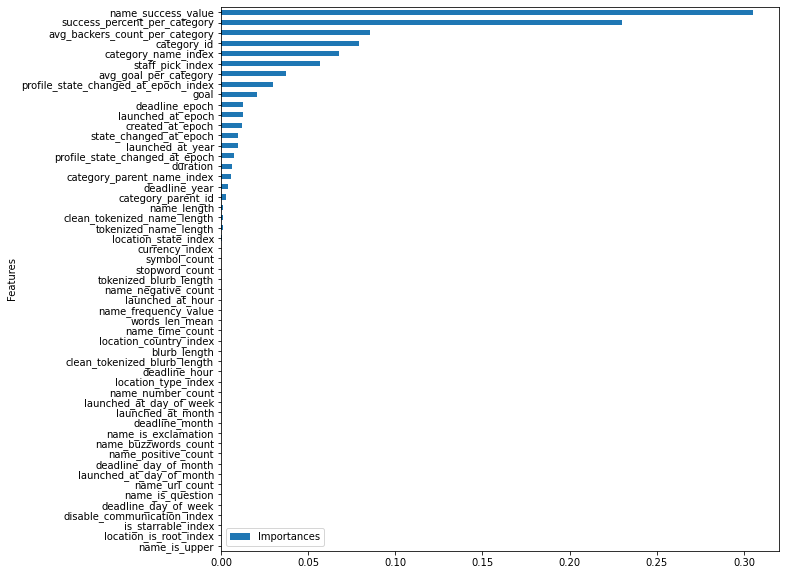

In [62]:
plot_feature_importances(feature_importances, training_columns)

### RFC with Main Features

In [63]:
main_feature_importances = []

for i in range(0, len(feature_importances)):
    if feature_importances[i] > 0.001:
        main_feature_importances.append(training_columns[i])

main_feature_importances

['category_id',
 'category_parent_id',
 'goal',
 'created_at_epoch',
 'deadline_epoch',
 'launched_at_epoch',
 'state_changed_at_epoch',
 'profile_state_changed_at_epoch',
 'category_name_index',
 'category_parent_name_index',
 'profile_state_changed_at_epoch_index',
 'staff_pick_index',
 'launched_at_year',
 'deadline_year',
 'duration',
 'avg_backers_count_per_category',
 'avg_goal_per_category',
 'success_percent_per_category',
 'clean_tokenized_name_length',
 'tokenized_name_length',
 'name_length',
 'name_success_value']

Create train and val data for RFC woth main features:

In [64]:
assembler = VectorAssembler(inputCols=main_feature_importances, outputCol='features', handleInvalid="keep")
train_data_feed = assembler.transform(df).select('features', 'state_index')

train_data, val_data = train_data_feed.randomSplit([0.7, 0.3])

Create RFC model:

In [65]:
rfc = RandomForestClassifier(labelCol='state_index', featuresCol='features', numTrees=200)
rfc_model = rfc.fit(train_data)
rfc_preds = rfc_model.transform(val_data)
evaluator = BinaryClassificationEvaluator(labelCol='state_index')

print(f'RFC prediction AUC: {evaluator.evaluate(rfc_preds)}')

RFC prediction AUC: 0.920703443954983


* Not a much better results

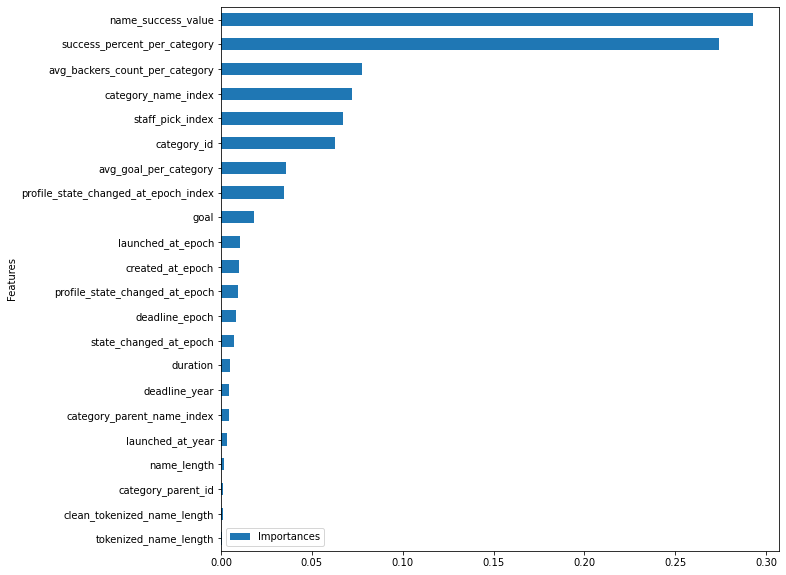

In [66]:
plot_feature_importances(rfc_model.featureImportances, main_feature_importances)

### RFC for Name Features Only

In [67]:
name_features = [
#  'clean_tokenized_name_length',
#  'tokenized_name_length',
#  'name_length',
 'words_len_mean',
 'name_number_count',
 'name_time_count',
 'name_url_count',
 'stopword_count',
 'symbol_count',
 'name_is_question',
 'name_is_exclamation',
 'name_is_upper',
 'name_negative_count',
 'name_positive_count',
 'name_buzzwords_count',
 'name_frequency_value',
#  'name_success_value'
 ]

Create train and val data for RFC for name features:

In [68]:
assembler = VectorAssembler(inputCols=name_features, outputCol='features', handleInvalid="keep")
train_data_feed = assembler.transform(df).select('features', 'state_index')

train_data, val_data = train_data_feed.randomSplit([0.7, 0.3])

Create RFC model:

In [69]:
rfc = RandomForestClassifier(labelCol='state_index', featuresCol='features', numTrees=200)
rfc_model = rfc.fit(train_data)
rfc_preds = rfc_model.transform(val_data)
evaluator = BinaryClassificationEvaluator(labelCol='state_index')

print(f'RFC prediction AUC: {evaluator.evaluate(rfc_preds)}')

RFC prediction AUC: 0.5816955034645747


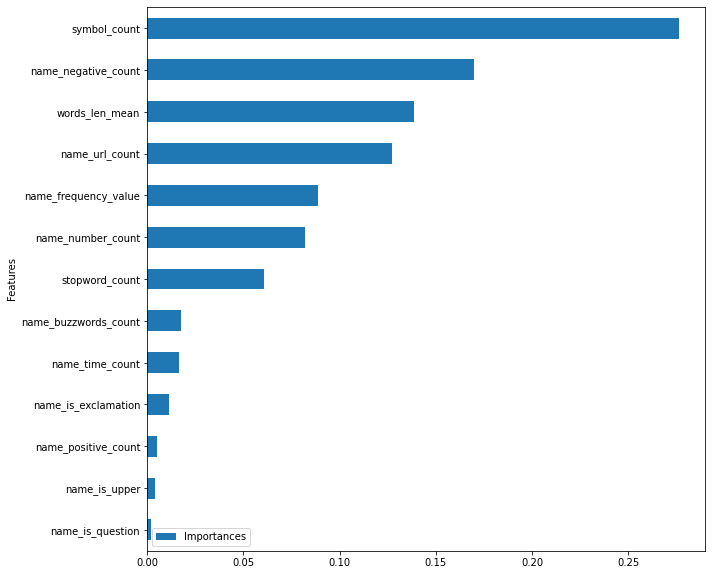

In [70]:
plot_feature_importances(rfc_model.featureImportances, name_features)

## SVM

In [71]:
df_svm = df.withColumnRenamed('state_index', 'label')

Create train and val data for SVM:

In [72]:
assembler = VectorAssembler(inputCols=training_columns, outputCol='features', handleInvalid="keep")
train_data_feed = assembler.transform(df_svm).select('features', 'label')

train_data, val_data = train_data_feed.randomSplit([0.7, 0.3])

In [73]:
svm = LinearSVC(maxIter=10, regParam=0.1)
model = svm.fit(train_data)
val_prediction = model.transform(val_data)

In [74]:
evaluator = BinaryClassificationEvaluator()

print(f'Evaluation (area under ROC): {evaluator.evaluate(val_prediction)}')

Evaluation (area under ROC): 0.914701589147107


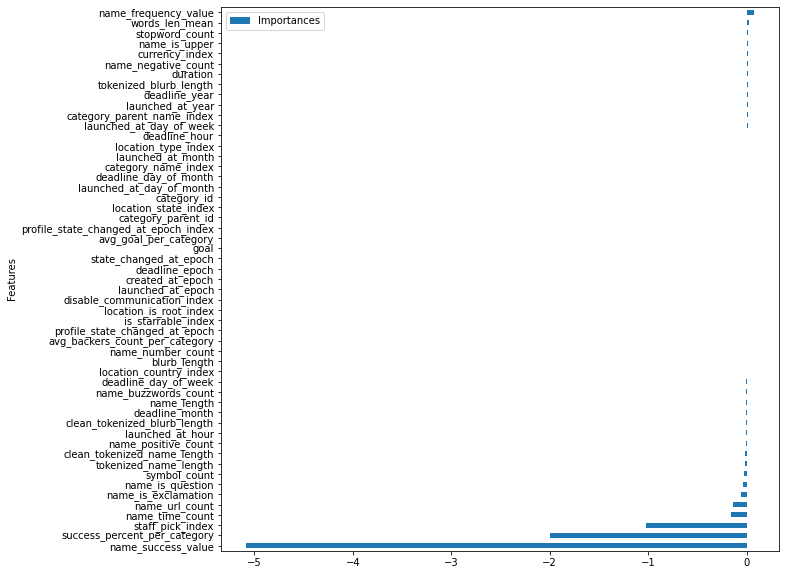

In [75]:
plot_feature_importances(model.coefficients, training_columns)

In [ ]:
spark.close()

# Part 5.3: Conclusion

### * Random Forest Classifier gives better prediction result over SVM for the success of a Kickstart project.
### * The main group of features that affects the success of a project are: name success value, categories and goals.
### * The main features that affects on the succes as part of the name of the project are: symbol count, negative words count and words length
